This notebook creates a neural network model to play tic tac toe.

In [7]:
import numpy as np
import pandas as pd
# import pytorch
import torch
import matplotlib.pyplot as plt

In [86]:
# Create a tic tac toe game class.
class TicTacToe:
    """
    A class to represent a tic tac toe game.
    """
    def __init__(self):
        """
        Initialize the game.
        """
        self.board = np.zeros((3, 3))
        self.player = 1
        self.winner = None
        self.game_over = False

    def reset(self):
        """
        Reset the game.
        """
        self.board = np.zeros((3, 3))
        self.player = 1
        self.winner = None
        self.game_over = False

    def print_board(self):
        """
        Print the board.
        """
        print(self.board)

    def make_move(self, row, col):
        """
        Make a move on the board.
        row: row index
        col: column index
        """
        if self.board[row, col] == 0:
            self.board[row, col] = self.player
            self.check_winner()
            self.player = -self.player
            return True
        else:
            return False

    def check_winner(self):
        """
        Check if there is a winner.
        """
        for i in range(3):
            if self.board[i, 0] == self.board[i, 1] == self.board[i, 2] != 0:
                self.winner = self.board[i, 0]
                self.game_over = True
            if self.board[0, i] == self.board[1, i] == self.board[2, i] != 0:
                self.winner = self.board[0, i]
                self.game_over = True
        if self.board[0, 0] == self.board[1, 1] == self.board[2, 2] != 0:
            self.winner = self.board[0, 0]
            self.game_over = True
        if self.board[0, 2] == self.board[1, 1] == self.board[2, 0] != 0:
            self.winner = self.board[0, 2]
            self.game_over = True
        if np.all(self.board != 0):
            self.game_over = True
    def get_random_valid_move(self):
        """
        Get a random valid move.
        """
        valid_moves = np.argwhere(self.board == 0)
        idx = np.random.choice(valid_moves.shape[0])
        return valid_moves[idx]
    def get_valid_moves(self):
        """
        Get all valid moves.
        """
        return np.argwhere(self.board == 0)
    
            

In [87]:
# Test the game by making random moves until there is a winner or the game is over.
game = TicTacToe()
while not game.game_over:
    row = np.random.randint(3)
    col = np.random.randint(3)
    game.make_move(row, col)
    game.print_board()
# Print the winner.
if game.winner is not None:
    print('Player', game.winner, 'wins!')
else:
    print('It is a tie!')

[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
It is a tie!


In [426]:
class RandomPlayer:
    def go_once(self, tic_tac_toe: TicTacToe):
        row, col = tic_tac_toe.get_random_valid_move()
        return tic_tac_toe.make_move(row, col)
class GreedyPlayer:
    def go_once(self, tic_tac_toe: TicTacToe):
        """
        Make a winning move if possible.
        Block the opponent from winning if possible.
        Otherwise, make a random move.
        """
        # Get player number.
        player = tic_tac_toe.player
        # Get the board.
        board = tic_tac_toe.board
        # Check for a winning move.
        for i in range(3):
            if np.sum(board[i, :]) == 2 * player:
                col = np.argwhere(board[i, :] == 0)[0][0]
                return tic_tac_toe.make_move(i, col)
            if np.sum(board[:, i]) == 2 * player:
                row = np.argwhere(board[:, i] == 0)[0][0]
                return tic_tac_toe.make_move(row, i)
        if np.sum(np.diag(board)) == 2 * player:
            idx = np.argwhere(np.diag(board) == 0)[0][0]
            return tic_tac_toe.make_move(idx, idx)
        if np.sum(np.diag(np.fliplr(board))) == 2 * player:
            idx = np.argwhere(np.diag(np.fliplr(board)) == 0)[0][0]
            return tic_tac_toe.make_move(idx, 2 - idx)
        # Check for a blocking move.
        for i in range(3):
            if np.sum(board[i, :]) == -2 * player:
                col = np.argwhere(board[i, :] == 0)[0][0]
                return tic_tac_toe.make_move(i, col)
            if np.sum(board[:, i]) == -2 * player:
                row = np.argwhere(board[:, i] == 0)[0][0]
                return tic_tac_toe.make_move(row, i)
        if np.sum(np.diag(board)) == -2 * player:
            idx = np.argwhere(np.diag(board) == 0)[0][0]
            return tic_tac_toe.make_move(idx, idx)
        if np.sum(np.diag(np.fliplr(board))) == -2 * player:
            idx = np.argwhere(np.diag(np.fliplr(board)) == 0)[0][0]
            return tic_tac_toe.make_move(idx, 2 - idx)
        # Make a random move.
        row, col = tic_tac_toe.get_random_valid_move()
        return tic_tac_toe.make_move(row, col)

class AIPlayer:
    def __init__(self):
        self.model = torch.nn.Sequential(
            torch.nn.Linear(9, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 9)
        )
        self.learning_rate = 1e-3
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.loss = torch.nn.BCEWithLogitsLoss()
        self.game_results = []
    def go_once(self, tic_tac_toe: TicTacToe):
        board_state = torch.tensor(tic_tac_toe.board.reshape(1, 9), dtype=torch.float32)
        # If we are player 2, we need to flip the board.
        if tic_tac_toe.player == -1:
            board_state = -board_state
        prediction = self.model(board_state)
        best_move = torch.argmax(prediction)
        row = best_move // 3
        col = best_move % 3
        is_valid = tic_tac_toe.make_move(row, col)
        if not is_valid:
            row, col = tic_tac_toe.get_random_valid_move()
            is_valid = tic_tac_toe.make_move(row, col)
        
    def train(self, iterations: int, other):
        """
        Train the player against a random opponent.
        """
        for _ in range(iterations):
            game = TicTacToe()
            game_timeout = 25
            game_counter = 0
            while not game.game_over:
                game_counter += 1
                if game_counter > game_timeout:
                    break
                # Get the board state.
                board_state = torch.tensor(game.board.reshape(1, 9), dtype=torch.float32)
                # Get the model prediction.
                prediction = self.model(board_state)
                # Get the best move.
                best_move = torch.argmax(prediction)
                # Make the move.
                row = best_move // 3
                col = best_move % 3
                is_valid = game.make_move(row, col)
                if not is_valid:
                    # Force a random valid move.
                    row, col = game.get_random_valid_move()
                    game.make_move(row, col)

                # Determine the loss.
                target = torch.zeros(1, 9)
                if not is_valid:
                    # Invalid move
                    # Make the target be any valid move
                    
                    valid_moves = game.get_valid_moves()
                    for move in valid_moves:
                        idx = move[0] * 3 + move[1]
                        target[0, idx] = 1
                    
                elif game.winner == 1:
                    # Victory
                    # Make the target be the best move
                    target[0, best_move] = 1
                elif game.game_over:
                    # Tie
                    # Make the target be the best move
                    target[0, best_move] = 1
                elif is_valid:
                    # Other player makes a random valid move.
                    other.go_once(game)
                    if game.winner == -1:
                        # Defeat
                        # Make the target be any other move except the best move
                        valid_moves = game.get_valid_moves()
                        for move in valid_moves:
                            idx = move[0] * 3 + move[1]
                            if idx != best_move:
                                target[0, idx] = 1
                    elif game.game_over:
                        # Tie
                        # Make the target be any other move except the best move
                        valid_moves = game.get_valid_moves()
                        for move in valid_moves:
                            idx = move[0] * 3 + move[1]
                            if idx != best_move:
                                target[0, idx] = 1
                else:
                    # Continue the game
                    # Make the target be any other move except the best move
                    valid_moves = game.get_valid_moves()
                    for move in valid_moves:
                        idx = move[0] * 3 + move[1]
                        if idx != best_move:
                            target[0, idx] = 1
                        
                # Compute the loss.
                loss = self.loss(prediction, target)
                # Optimize the model.
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            self.game_results.append(game.winner if game.winner is not None else 0)
                

In [433]:
# Create an AI player.
ai_player = AIPlayer()
# Create a random player.
random_player = RandomPlayer()
# Train the AI player.
ai_player.train(iterations=2000, other=random_player)


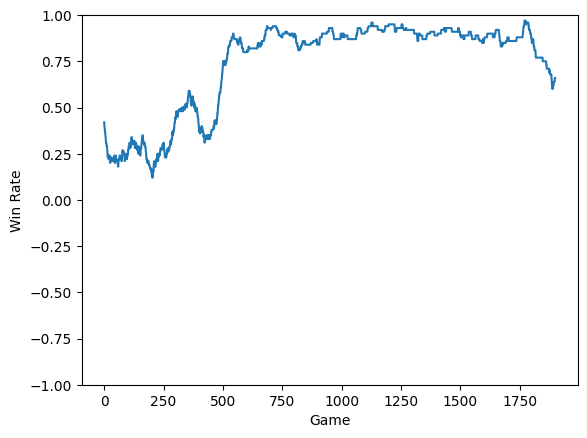

In [434]:
# Plot the game training results.
# Calculate the moving average.
window_size = 100
moving_average = np.convolve(ai_player.game_results, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_average)
plt.xlabel('Game')
plt.ylabel('Win Rate')
plt.ylim([-1, 1])
plt.show()


In [435]:
# Train the AI against a greedy player.
ai_player = AIPlayer()
greedy_player = GreedyPlayer()
ai_player.train(iterations=2000, other=greedy_player)


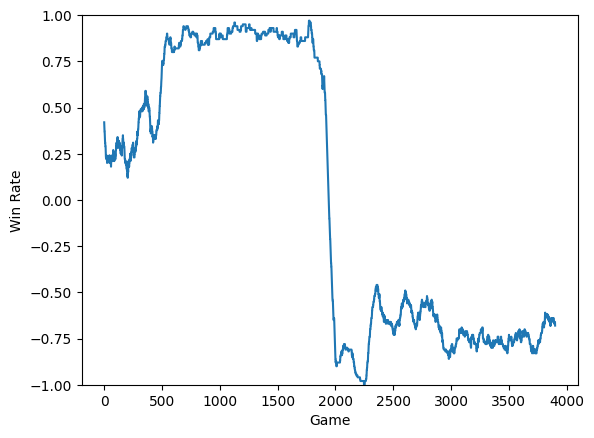

In [436]:
# Plot the game training results.
# Calculate the moving average.
window_size = 100
moving_average = np.convolve(ai_player.game_results, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_average)
plt.xlabel('Game')
plt.ylabel('Win Rate')
plt.ylim([-1, 1])
plt.show()
